In [1]:
from utils.data import Dataset
from utils.conllu import read_conllu_dataset
import numpy as np

In [2]:
dataset = Dataset()

train_sentences = read_conllu_dataset("data/ro_rrt-ud-train.conllu")
test_sentences = read_conllu_dataset("data/ro_rrt-ud-test.conllu")

# Fit on training data
X_train, y_train = dataset.fit(train_sentences, mode="chars")

# Encode test data (fixed shape)
X_test, y_test = dataset.encode(test_sentences)

In [3]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8043, 163, 55), (8043, 163, 17), (729, 163, 55), (729, 163, 17))

In [4]:
import tensorflow as tf

In [5]:
_, seq_len, char_feat_len = X_train.shape
output_dim = y_train.shape[-1]

In [6]:
sample_weight = np.where(np.argmax(y_train, axis=-1) != 0, 1.0, 0.0)

In [7]:
input_layer = tf.keras.layers.Input(shape=(seq_len, char_feat_len))
#lstm = tf.keras.layers.LSTM(256, return_sequences=True)(input_layer)
x = tf.keras.layers.Conv1D(64, kernel_size=(11,), padding="same")(input_layer)
x = tf.keras.layers.Conv1D(128, kernel_size=(7,), padding="same")(x)
x = tf.keras.layers.Conv1D(256, kernel_size=(3,), padding="same")(x)
output_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_dim, activation='softmax'))(x)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', weighted_metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 163, 55)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 163, 64)        │        38,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 163, 128)       │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 163, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 163, 17)        │         4,369 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,185 (778.07 KB)

 Trainable params: 199,185 (778.07 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    sample_weight = sample_weight
)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.4332 - loss: 0.2479 - val_accuracy: 0.5438 - val_loss: 0.2155
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.5215 - loss: 0.2031 - val_accuracy: 0.5432 - val_loss: 0.2128
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.5252 - loss: 0.2013 - val_accuracy: 0.5466 - val_loss: 0.2109
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.5302 - loss: 0.1970 - val_accuracy: 0.5452 - val_loss: 0.2129
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.5284 - loss: 0.1964 - val_accuracy: 0.5428 - val_loss: 0.2124
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.5303 - loss: 0.1973 - val_accuracy: 0.5238 - val_loss: 0.2167
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.5309 - loss: 0.1961 - val_accuracy: 0.5297 - val_loss: 0.2152
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.5281 - loss: 0.1964 - val_accu

In [9]:
import matplotlib.pyplot as plt

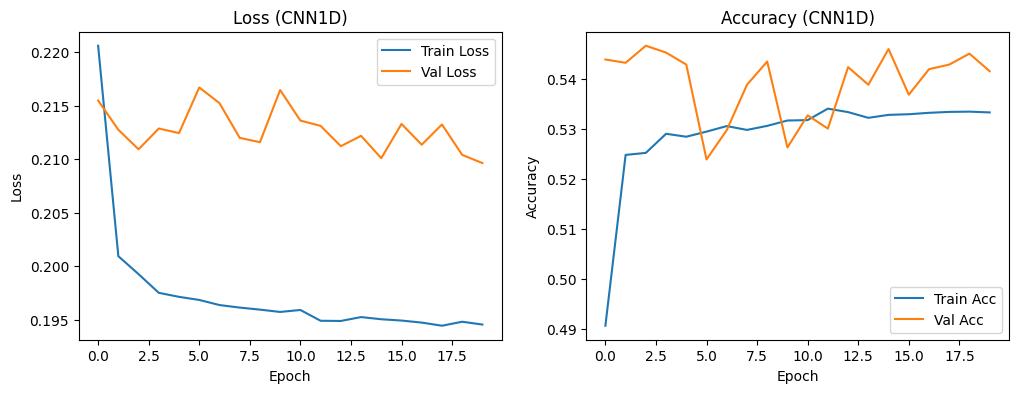

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Loss (CNN1D)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy (CNN1D)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [11]:
model.save('pos_cnn1d_model.keras')

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test, sample_weight=np.where(np.argmax(y_test, axis=-1) != 0, 1.0, 0.0))
print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.5168 - loss: 0.1959

Test Loss: 0.1958 | Test Accuracy: 0.5230


In [13]:
import numpy as np
y_pred = model.predict(X_test)
y_pred_ids = np.argmax(y_pred, axis=-1)
y_true_ids = np.argmax(y_test, axis=-1)

# Reverse label index
idx2label = {i: l for l, i in dataset.label2id.items()}

# Show sample predictions
for i in range(3):
    print(f"\n--- Sentence {i+1} ---")
    for j in range(seq_len):
        word_vec = X_test[i, j]
        if np.all(word_vec == 0): continue  # padding

        pred_label = idx2label.get(y_pred_ids[i, j]-1, "UNK")
        true_label = idx2label.get(y_true_ids[i, j]-1, "UNK")
        print(f"{j:2}: Pred: {pred_label:6} | True: {true_label}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 480ms/step

--- Sentence 1 ---
 0: Pred: INTJ   | True: INTJ
 1: Pred: ADV    | True: PART
 2: Pred: ADV    | True: SCONJ
 3: Pred: SCONJ  | True: SCONJ
 4: Pred: ADP    | True: ADP
 5: Pred: PART   | True: PART
 6: Pred: PROPN  | True: ADV
 7: Pred: INTJ   | True: SCONJ
 8: Pred: ADJ    | True: ADJ
 9: Pred: INTJ   | True: INTJ
10: Pred: PROPN  | True: PROPN

--- Sentence 2 ---
 0: Pred: ADJ    | True: ADJ
 1: Pred: SCONJ  | True: INTJ
 2: Pred: AUX    | True: PART
 3: Pred: INTJ   | True: SCONJ
 4: Pred: PROPN  | True: CCONJ
 5: Pred: INTJ   | True: INTJ
 6: Pred: ADJ    | True: ADJ
 7: Pred: INTJ   | True: INTJ
 8: Pred: INTJ   | True: <PAD>
 9: Pred: ADJ    | True: ADJ
10: Pred: INTJ   | True: INTJ
11: Pred: AUX    | True: AUX
12: Pred: ADJ    | True: CCONJ
13: Pred: INTJ   | True: INTJ
14: Pred: INTJ   | True: PART
15: Pred: ADJ    | True: PART
16: Pred: INTJ   | True: SCONJ
17: Pred: INTJ   | True: ADJ
18: Pred: ADJ    | True: PART
19: Pred: PROPN  

In [14]:
np.argmax(y_test, axis=-1)[0]

array([ 8, 11, 15, 15,  3, 11,  4, 15,  2,  8, 13,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [15]:
y_true_flat = y_true_ids.reshape((-1,))
y_pred_flat = y_pred_ids.reshape((-1,))
mask = (y_true_flat != 0)
y_true_flat = y_true_flat[mask]
y_pred_flat = y_pred_flat[mask]

np.max(y_true_flat), np.min(y_true_flat), np.max(y_pred_flat), np.min(y_pred_flat)

np.sum(y_true_flat==7), np.sum(y_pred_flat==7)


(np.int64(6), np.int64(0))

Classification Report:


d:\anu1m\sem2\NLP\soft\PoSTagging\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anu1m\sem2\NLP\soft\PoSTagging\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anu1m\sem2\NLP\soft\PoSTagging\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resul

              precision    recall  f1-score   support

       <PAD>       0.00      0.00      0.00         0
         ADJ       0.48      0.14      0.21      1172
         ADP       0.55      0.78      0.64      2333
         ADV       0.34      0.06      0.11       650
         AUX       0.26      0.11      0.15       618
       CCONJ       0.88      0.70      0.78       471
         DET       0.21      0.13      0.16       898
        INTJ       0.00      0.00      0.00         6
        NOUN       0.45      0.86      0.59      4042
         NUM       0.41      0.09      0.15       456
        PART       0.62      0.27      0.38       358
        PRON       0.37      0.09      0.15       862
       PROPN       0.00      0.00      0.00       455
       PUNCT       0.78      0.95      0.86      2083
       SCONJ       0.33      0.10      0.16       154
        VERB       0.49      0.17      0.25      1749
           X       0.00      0.00      0.00        17

    accuracy              

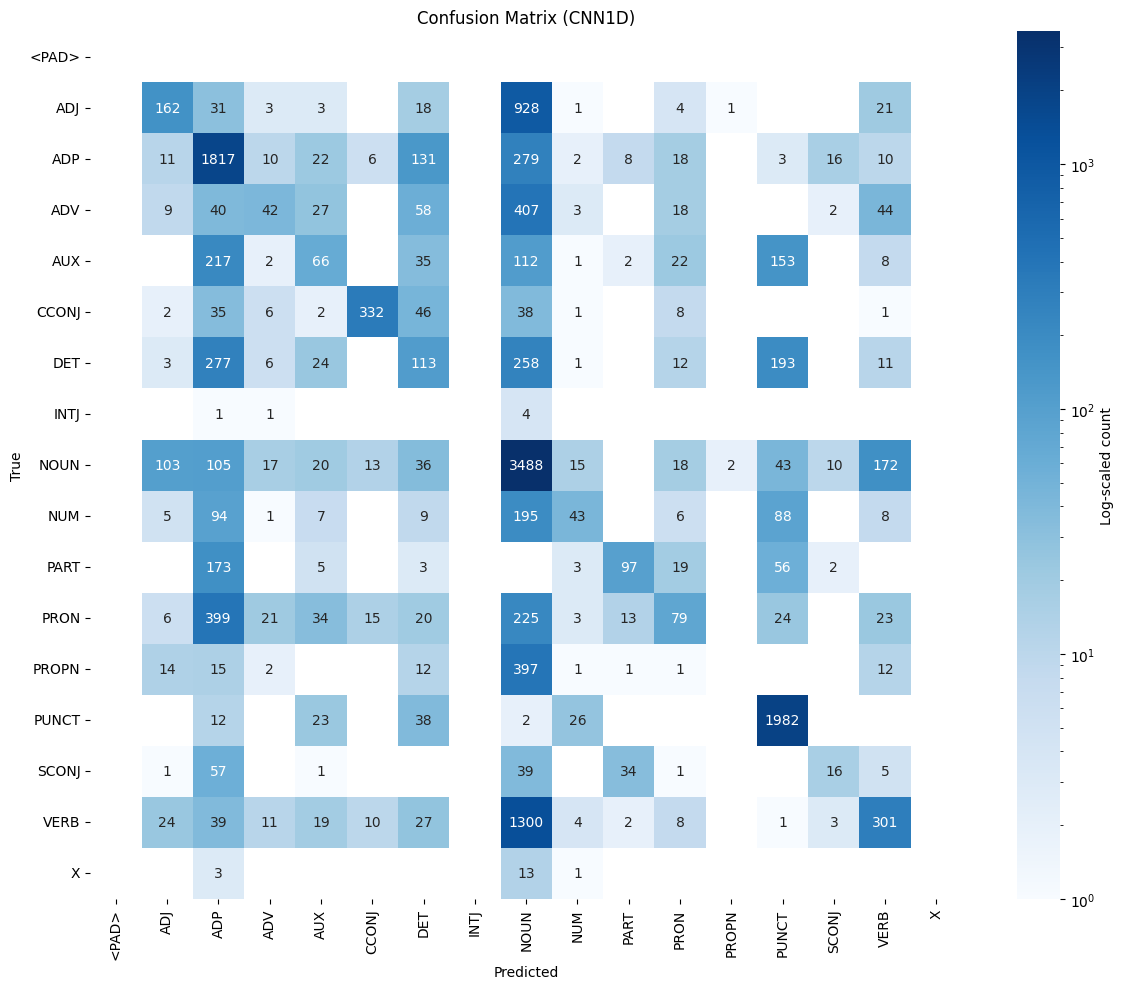

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from matplotlib.colors import LogNorm

# Compute confusion matrix
labels = dataset.labels
label_ids = list(range(len(labels)))

print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, labels=label_ids, target_names=labels))

cm = confusion_matrix(y_true_flat, y_pred_flat, labels=label_ids)

# Plot with log scale
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', norm=LogNorm(vmin=1, vmax=cm.max()),
            xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Log-scaled count'})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (CNN1D)")
plt.tight_layout()
plt.show()
